In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.python.ops import math_ops

# Add parent directory to path to 
# allow imports of custom modules
if not '..' in sys.path:
    sys.path.append('..')
    
from models.losses import SimilarityLoss
from utils.generic import progress_bar
from utils.data.gen import \
    get_toy_dataset, \
    create_triplets_from_augmentations, \
    create_class_triplets, \
    create_triplets_from_hierarchical_classes
from utils.data.preproc import add_random_noise

In [2]:
PROJECT_HOME = '../../'
VIS_PATH = PROJECT_HOME+'vis/'

(160, 2)

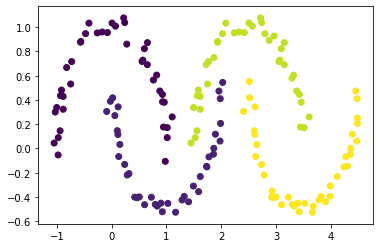

In [3]:
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification, make_gaussian_quantiles

# Create data set
X, y = get_toy_dataset('hierarchies', n_samples=200, std=0.05, n_classes=2, seed=132)
X, X_t, y, y_t = train_test_split(X, y, test_size=0.2, random_state=133)
plt.scatter(X[:,0], X[:,1], c=y)
X.shape

In [4]:
data = create_triplets_from_hierarchical_classes(X, y, b=50)
#data = create_class_triplets(X, y)[:,:200000,:]
data.shape

Combination 10 10 11
Combination 10 10 20
Combination 10 10 21
Combination 10 11 20
Combination 10 11 21
Combination 11 10 20
Combination 11 10 21
Combination 11 11 10
Combination 11 11 20
Combination 11 11 21
Combination 20 20 10
Combination 20 20 11
Combination 20 20 21
Combination 20 21 10
Combination 20 21 11
Combination 21 20 10
Combination 21 20 11
Combination 21 21 10
Combination 21 21 11
Combination 21 21 20
Created triplets.
Casting to numpy array ...
Shuffling ...
Transposing axis 0 and 1 ...
Done.


(3, 2500000, 2)

# Create Model

In [6]:
n_in_nodes = X.shape[1]
n_out_nodes = 2
n_hidden = 80

def create_base_network(inp_shape):
    inp = keras.Input(shape=inp_shape)
    hidden = layers.Dense(n_hidden, 'relu')(inp)
    out = layers.Dense(n_out_nodes, 'linear')(hidden)
    return keras.Model(inp, out)

emb = create_base_network(inp_shape=n_in_nodes) # output_shape : (None, 2)

ins = [keras.Input(shape=n_in_nodes, name=str(i)) for i in range(3)]
x = [emb(ins[i]) for i in range(3)]
x = layers.Concatenate()(x) # (None, 6)
x = layers.Reshape((3,n_out_nodes))(x) # (None, 3, 2)

model = keras.Model(ins, x)
print(model.input_shape, model.output_shape)
# Input shape : (3, None, 2)
# Output shape : (None, 3, 2)

[(None, 2), (None, 2), (None, 2)] (None, 3, 2)


In [7]:
similarity_loss = SimilarityLoss(gamma=1, beta=1, alpha=1)
optimizer = tf.keras.optimizers.Adam()
loss_history = []

In [14]:
bs = 250

def forward_pass(inp, training=False):
    logits = model(inp, training=training)
    loss_value = similarity_loss(logits)
    return logits, loss_value

def train_step(batch):
    with tf.GradientTape() as tape:
        logits, loss_value = forward_pass(batch, training=True)
    mean_loss = loss_value.numpy().mean()
    loss_history.append(mean_loss)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return mean_loss

def train(epochs, steps_per_epoch=None):
    
    if steps_per_epoch:
        max_steps = steps_per_epoch
    else:
        max_steps = len(data[0])//bs
    
    for epoch in range(1,epochs+1):
        print('Epoch {}'.format(epoch))

        step = 0
        for i in range(0, len(data[0]), bs):
            batch = [data[0,i:i+bs,:],data[1,i:i+bs,:],data[2,i:i+bs,:]]
            loss_value = train_step(batch)

            if step % 200 == 0:
                print('{} batch {}/{} | loss: {:.6f} \r'
                      .format(progress_bar(step/max_steps), 
                              step, 
                              max_steps,
                              float(loss_value)), 
                      end='')
            if step == max_steps:
                break            
            step += 1
                    
        # Compute mean loss over epoch
        all_data = [data[0,:,:],data[1,:,:],data[2,:,:]]
        _, loss_value = forward_pass(all_data)
        whole_mean_loss = loss_value.numpy().mean()
        print('{} batch {}/{} | mean_loss: {:.6f} \r'
                      .format(progress_bar(1.), 
                              max_steps, 
                              max_steps,
                              float(whole_mean_loss)), 
                      end='')
                
        print('\n')
                
train(2)#, steps_per_epoch=500)

Epoch 1
[=========================] batch 10000/10000 | mean_loss: 0.040963 

Epoch 2


KeyboardInterrupt: 

In [15]:
all_data = [data[0,:,:],data[1,:,:],data[2,:,:]]
_, loss_value = forward_pass(all_data)
mean_loss = loss_value.numpy().mean()
mean_loss

0.00017370317

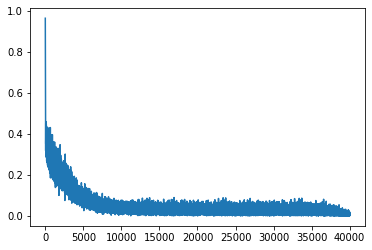

In [12]:
plt.plot(loss_history)
#plt.savefig(VIS_PATH+'poopy_history')

## Visualize learned representations

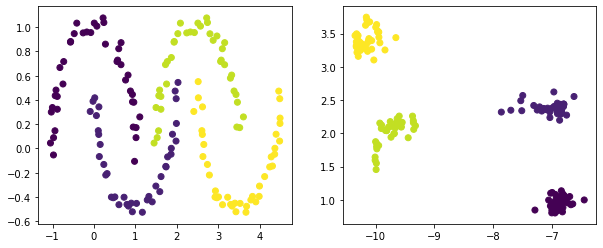

In [16]:
def get_projection(dp):
    return list(emb(np.array([dp])).numpy()[0])
    #return list(model([np.array([dp]),np.array([[0]*n_in_nodes]),np.array([[0]*n_in_nodes])]).numpy()[0,0])

Y_Hat = np.array([get_projection(dp) for dp in X])

if n_out_nodes == 1:
    axarr = np.array([[0.]]*Y_Hat.shape[0])
    Y_Hat = np.concatenate((Y_Hat, axarr), axis = 1)
    print('Extended 1-D projections for plotting.')
    
fig, ax = plt.subplots(1,2,figsize=(10,4))
#ax[0].axis('off')
ax[0].scatter(X[:,0], X[:,1], c=y)
#ax[1].axis('off')
ax[1].scatter(Y_Hat[:,0], Y_Hat[:,1], c=y)
#plt.savefig(VIS_PATH+'hierarchical_class_triplets')
plt.show()

## Linear classifier on last layer

Building models ...
Fitting pre-trained model ...
Fitting random model ...


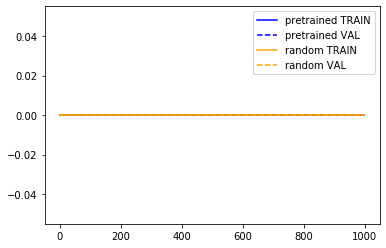

5/5 [==============================] - 0s 862us/step - loss: 0.0000e+00 - acc: 0.0000e+00


([0.0, 0.0], [0.0, 0.0])

In [17]:
def test_linear_clf(embnet, X, y, X_t, y_t):

    print('Building models ...')
       
    # Extend embedding network with linear classification layer
    x = embnet.output
    x = layers.Dense(len(np.unique(y)), 'softmax', name='linear_classifier')(x)
    linear_model = keras.Model(inputs=embnet.input, outputs=x)
    # Fix weights of all embedding layers, only leave classifier
    for i in range(3):
        linear_model.layers[i].trainable = False
    # Compile with cross entropy loss for classification
    linear_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['acc'])

    # Build randomly initialized model for comparison
    inp = keras.Input(shape=embnet.input_shape[-1])
    x = layers.Dense(embnet.layers[1].output_shape[-1], 'relu')(inp)
    x = layers.Dense(n_out_nodes, 'linear')(x)
    x = layers.Dense(len(np.unique(y)), 'softmax', name='linear_classifier')(x)
    rand_model = keras.Model(inp, x)
    # Compile with cross entropy loss for classification
    rand_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['acc'])
 
    # Make y-vector one hot
    y_onehot = tf.one_hot(y, depth=len(np.unique(y)))
    y_t_onehot = tf.one_hot(y_t, depth=len(np.unique(y)))
    
    # Fit the models
    epochs=1000
    print('Fitting pre-trained model ...')
    history1 = linear_model.fit(X, y_onehot, verbose=0, epochs=epochs,
                              validation_data=(X_t,y_t_onehot))
    print('Fitting random model ...')
    history2 = rand_model.fit(X, y_onehot, verbose=0, epochs=epochs,
                              validation_data=(X_t,y_t_onehot))
    
    # Plot the training histories, skipping first 100 epochs
    skip = 0
    plt.plot(history1.history['loss'][skip:], label='pretrained TRAIN', c='b')
    plt.plot(history1.history['val_loss'][skip:], label='pretrained VAL', c='b', ls='--')
    plt.plot(history2.history['loss'][skip:], label='random TRAIN', c='orange')
    plt.plot(history2.history['val_loss'][skip:], label='random VAL', c='orange', ls='--')
    plt.legend()
    plt.show()
    
    # Return evaluation score
    return (linear_model.evaluate(X,y_onehot), rand_model.evaluate(X,y_onehot))

test_linear_clf(emb, X, y, X_t, y_t)

## Classifying embeddings with LinearSVC

In [33]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [34]:
emb_train = np.array([get_projection(dp) for dp in X])
emb_test = np.array([get_projection(dp) for dp in X_t])

In [43]:
svc = LinearSVC(max_iter=3000)
svc.fit(emb_train, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [44]:
y_pred = svc.predict(emb_test)
accuracy_score(y_t, y_pred)

1.0

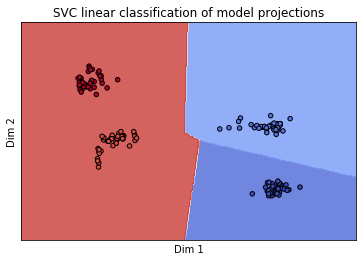

In [45]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

C = 1.0  # SVM regularization parameter

X0, X1 = emb_train[:, 0], emb_train[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots(1,1)
plot_contours(ax, svc, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('SVC linear classification of model projections')

plt.show()